In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path 
import PIL
from PIL import Image, ImageDraw
import statistics

In [2]:
#count total area of organs and count each organ


#iniit parameters
number_of_img_per_foalder = []
number_of_img_total = 0


organ_areas = {
    'heart': 0,
    'thoracic_cavity': 0,
    'left_kidney': 0,
    'right_kidney': 0,
    'liver': 0,
    'portal_vien': 0,
    'vena_cava': 0,
    'aorta': 0,
    'portal_vien_entry_point': 0,
    'spleen': 0
}

organ_counts = {
    'heart': 0,
    'thoracic_cavity': 0,
    'left_kidney': 0,
    'right_kidney': 0,
    'liver': 0,
    'portal_vien': 0,
    'vena_cava': 0,
    'aorta': 0,
    'portal_vien_entry_point': 0,
    'spleen': 0
}




directory = r'C:\working_space\pilsen_pigs_2023_cvat_backup\workspase'
path = Path(directory)


#iteration part to collect statistics
for foalder in path.iterdir():

    for file in foalder.iterdir():

        if file.is_file():
            with open(file, 'r') as f:
                data = json.load(f)

            number_of_img_total += data['images'][-1]['id']
            number_of_img_per_foalder.append(data['images'][-1]['id'])
            organs = set()
            for i in range(len(data['annotations'])):
                category = data['annotations'][i]['category_id'] - 1
                name_of_category = list(organ_areas.keys())[category]
                if name_of_category not in organs:
                    organ_counts[name_of_category] += 1
                    organs.add(name_of_category)

                organ_areas[name_of_category] += data['annotations'][i]['area']

In [3]:
#get mean brightness of the segmented organs (for 2D)

directory = r'C:\working_space\pilsen_pigs_2023_cvat_backup\workspase'
path = Path(directory)


#in that entity key is number of category id, first list is mean brightness per 3D image,
#  second list contain list of lists in each position we have mean brightness per 2D image
brightness = {1:[[], []],
              2:[[], []],
              3:[[], []],
              4:[[], []],
              5:[[], []],
              6:[[], []],
              7:[[], []],
              8:[[], []],
              9:[[], []],
              10:[[], []]
              }

#iteration part to collect statistics
for foalder in path.iterdir():
    pictures = []

    for iter in foalder.iterdir():

        if iter.is_file() and iter.name.endswith('.json'):

            with open(iter, 'r') as f:
                data = json.load(f)

        elif iter.is_dir():

            for n in range(10):
                brightness[n+1][1].append([])
            
            for photo in iter.iterdir():
                picture = Image.open(photo).convert('L')
                pictures.append(picture)

        
        for annotation in range(len(data['annotations'])):
            img = pictures[data['annotations'][annotation]['image_id'] - 1]
            mask = Image.new('L', img.size, color=0)

            draw = ImageDraw.Draw(mask)
            segment = data['annotations'][annotation]['segmentation'][0]
            polygons = [(segment[i], segment[i + 1]) for i in range(0, len(segment), 2)]
            category = data['annotations'][annotation]['category_id']
            draw.polygon(polygons, outline=category, fill=category)

            gray_array = np.array(img)
            mask_array = np.array(mask)
            object_pixels = gray_array[mask_array == category]
            brightness[category][1][-1].append(statistics.mean(object_pixels))

        for item in range(10):
            if len(brightness[item+1][1][-1]) != 0:
                brightness[item+1][0].append(statistics.mean(brightness[item+1][1][-1]))


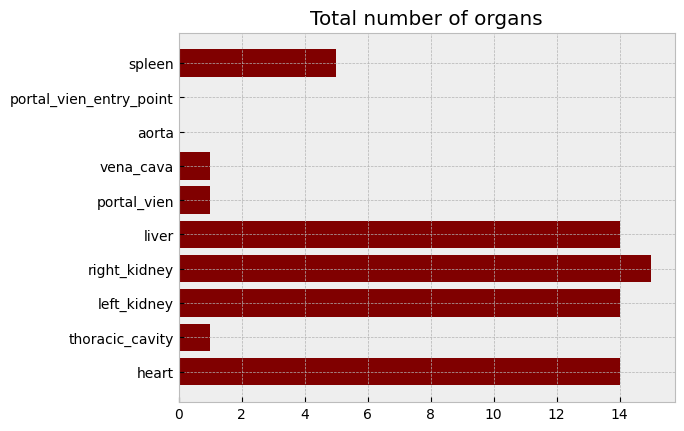

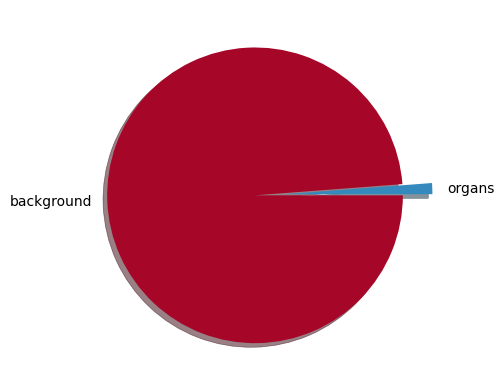

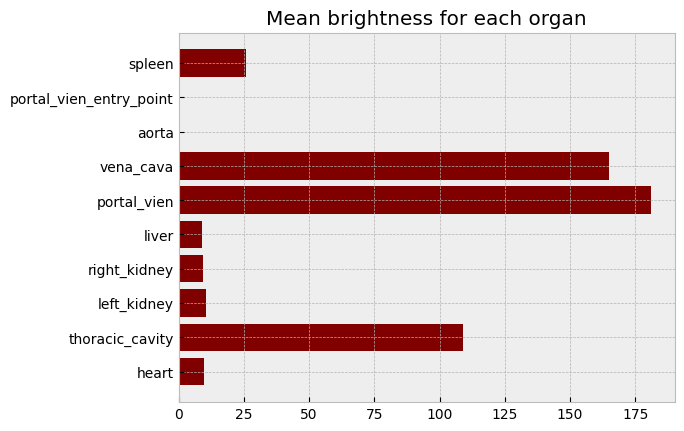

In [22]:
#visualization



#bar for total number of organs
number_of_organs = list(organ_counts.values())
name_of_organs = list(organ_counts.keys())

# creating the bar plot
plt.style.use('bmh')
plt.grid(True)
plt.barh(name_of_organs, number_of_organs, color ='maroon')
plt.title('Total number of organs')
plt.show()


#pie of area plot
y = []
x = ['organs', 'background']
labels = list(organ_areas.keys())

ct_area = 0 
for label in labels:
    area = (organ_areas[label]*100)/(512*512*number_of_img_total)
    ct_area += area                    
y.append(ct_area)
y.append(100 - y[-1])
y = np.array(y)



myexplode = [0, 0.2]
plt.pie(y, labels = x, explode = myexplode, shadow = True) 
plt.show()


#show mean brightness of each organ
mean_brightness = []
labels = list(organ_counts.keys())

for label in range(len(labels)):
    if brightness[label+1][0] != []:
        mean_brightness.append(statistics.mean(brightness[label+1][0])/(organ_counts[labels[label]]))
    else:
        mean_brightness.append(0)
mean_brightness = np.array(mean_brightness)


# creating the bar plot
plt.barh(labels, mean_brightness, color ='maroon')
plt.grid(True)
plt.title('Mean brightness for each organ')
plt.show()

